# Assignment 2

## Initialization

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/A2" #@param {type:"string"}
!ln -Ts "$folder" /content/A2> /dev/null

# Add the assignment folder to Python path
if '/content/A2' not in sys.path:
  sys.path.insert(0, '/content/A2')

# Install requirements
!pip install -qr /content/A2/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import urllib.request

from dataclasses import dataclass
from torch.utils.data import DataLoader
from tqdm import tqdm

from lstm_solution import LSTM
from utils.wikitext2 import Wikitext2
from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs
from run_exp_lstm import train, evaluate


## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularization, adding logs).

In [ ]:
@dataclass
class Arguments:
  # Data
  data_folder: str = '/content/A2/data'
  batch_size: int = 16

  # Model
  model: str = 'lstm'  # [lstm, gpt1]
  embeddings: str = '/content/A2/data/embeddings.npz'
  layers: int = 1

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 10
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  exp_id: str = 'debug'
  log: bool = True
  log_dir: str = '/content/A2/logs'
  seed: int = 42

  # Miscellaneous
  num_workers: int = 2
  device: str = 'cuda'
  progress_bar: bool = False
  print_every: int = 10

The 6 configurations you need to run in Problem 1. Be careful that there is no discrepency between the configurations defined in `run_exp_lstm.py` and the ones below. In case there is a difference, the version from `run_exp_lstm.py` should be considered the ones to run.

In [ ]:
# Note: if there is any discrepency with the configurations in run_exp_lstm.py, the
# version from run_exp_lstm.py should be the ones to use in Problem 1.
configs = {
  1: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adam'),
  2: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='momentum'),
  5: Arguments(model='lstm', layers=2, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  6: Arguments(model='lstm', layers=4, batch_size=16, log=True, epochs=10, optimizer='adamw')
}

In [ ]:
def main(args):
  # Seed the experiment, for repeatability
  seed_experiment(args.seed)

  # Dataloaders
  train_dataset = Wikitext2(args.data_folder, split="train")
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
  )

  valid_dataset = Wikitext2(args.data_folder, split="validation")
  valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  test_dataset = Wikitext2(args.data_folder, split="test")
  test_dataloader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  # Download the embeddings
  if not os.path.isfile(args.embeddings):
    print("No embedding file please place embedding.pkl in ./data")

  # Model
  if args.model == "lstm":
    model = LSTM.load_embeddings_from(
      args.embeddings, hidden_size=512, num_layers=args.layers
    )
  else:
    raise ValueError("Unknown model {0}".format(args.model))
  model.to(args.device)

  # Optimizer
  if args.optimizer == "adamw":
    optimizer = optim.AdamW(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
  elif args.optimizer == "sgd":
    optimizer = optim.SGD(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "momentum":
    optimizer = optim.SGD(
      model.parameters(),
      lr=args.lr,
      momentum=args.momentum,
      weight_decay=args.weight_decay,
    )

  print(
    f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
    f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
  )

  train_losses, valid_losses = [], []
  train_ppls, valid_ppls = [], []
  train_times, valid_times = [], []
  for epoch in range(args.epochs):

    tqdm.write(f"====== Epoch {epoch} ======>")

    loss, ppl, wall_time = train(epoch, model, train_dataloader, optimizer, args)
    train_losses.append(loss)
    train_ppls.append(ppl)
    train_times.append(wall_time)

    loss, ppl, wall_time = evaluate(epoch, model, valid_dataloader, args)
    valid_losses.append(loss)
    valid_ppls.append(ppl)
    valid_times.append(wall_time)

  test_loss, test_ppl, test_time = evaluate(
    epoch, model, test_dataloader, args, mode="test"
  )

  print(f"===== Best validation perplexity: {min(valid_ppls):.3f} =====>")

  return (
    train_losses,
    train_ppls,
    train_times,
    valid_losses,
    valid_ppls,
    valid_times,
    test_loss,
    test_ppl,
    test_time,
  )

In [ ]:
args = configs[3]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Similarly you can add and run the configs listed in 'run_exps_vit.py' for the problem 3

In [ ]:
train_loss = np.loadtxt('/content/A2/logs/debug/train_loss.txt')
valid_loss = np.loadtxt('/content/A2/logs/debug/valid_loss.txt')
train_ppl = np.loadtxt('/content/A2/logs/debug/train_ppl.txt')
valid_ppl = np.loadtxt('/content/A2/logs/debug/valid_ppl.txt')
train_time = np.loadtxt('/content/A2/logs/debug/train_time.txt')
test_time = np.loadtxt('/content/A2/logs/debug/test_time.txt')
timeTrain = np.mean(train_time)
timeTest = test_time

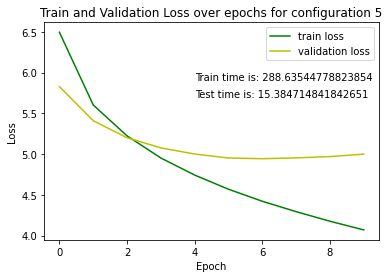

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'train loss', color = 'g')
plt.plot(valid_loss, label ='validation loss', color = 'y')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title( 'Train and Validation Loss over epochs for configuration 5')
plt.text(4,5.9,'Train time is: {}'.format(timeTrain))
plt.text(4,5.7,'Test time is: {}'.format(timeTest))
plt.legend()
plt.show()

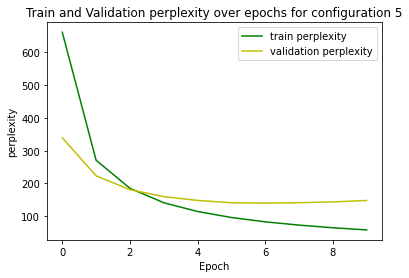

In [ ]:
plt.plot(train_ppl, label = 'train perplexity', color = 'g')
plt.plot(valid_ppl, label ='validation perplexity', color = 'y')
plt.ylabel('perplexity')
plt.xlabel('Epoch')
plt.title( 'Train and Validation perplexity over epochs for configuration 5')
plt.legend()
plt.show()

In [ ]:
valid_ppl1 = np.loadtxt('/content/A2/logs/Q1/valid_ppl.txt')


valid_ppl2 = np.loadtxt('/content/A2/logs/Q2/valid_ppl.txt')


valid_ppl3 = np.loadtxt('/content/A2/logs/Q3/valid_ppl.txt')


valid_ppl4 = np.loadtxt('/content/A2/logs/Q4/valid_ppl.txt')


valid_ppl5 = np.loadtxt('/content/A2/logs/Q5/valid_ppl.txt')


valid_ppl6 = np.loadtxt('/content/A2/logs/Q6/valid_ppl.txt')

In [ ]:
min(valid_ppl1), min(valid_ppl2), min(valid_ppl3), min(valid_ppl4),min(valid_ppl5),min(valid_ppl6)

(145.84111701488249,
 144.99050968067357,
 2173.959271498484,
 1653.3513251668003,
 140.13755202908183,
 157.50560424170166)

In [ ]:
import nvidia_smi

nvidia_smi.nvmlInit()

deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

nvidia_smi.nvmlShutdown()

In [ ]:
%cd /content/gdrive/MyDrive/A2

/content/gdrive/MyDrive/A2


In [ ]:
!python run_exp_vit.py --exp_id 11 --num_layers 2 --epochs 10 --optimizer "adam"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0.0
Initialized VIT model with 1086730 total parameters, of which 1086730 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.43170
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.66688
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.66914
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.48354
== [TRAIN] Epoch: 0, Accuracy: 0.374 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.71022
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.462 ===>
====== Epoch 1 ==

In [ ]:
train_loss1 = np.loadtxt('/content/A2/logs/1/train_loss.txt')
valid_loss1 = np.loadtxt('/content/A2/logs/1/valid_loss.txt')
train_ppl1 = np.loadtxt('/content/A2/logs/1/train_ppl.txt')
valid_ppl1 = np.loadtxt('/content/A2/logs/1/valid_ppl.txt')
train_time1 = np.loadtxt('/content/A2/logs/1/train_time.txt')
valid_time1 = np.loadtxt('/content/A2/logs/1/valid_time.txt')
gpu1 = np.loadtxt('/content/A2/logs/11/GPU_usage.txt')
#timeTrain1 = np.mean(train_time)


train_loss2 = np.loadtxt('/content/A2/logs/2/train_loss.txt')
valid_loss2 = np.loadtxt('/content/A2/logs/2/valid_loss.txt')
train_ppl2 = np.loadtxt('/content/A2/logs/2/train_ppl.txt')
valid_ppl2 = np.loadtxt('/content/A2/logs/2/valid_ppl.txt')
train_time2 = np.loadtxt('/content/A2/logs/2/train_time.txt')
valid_time2 = np.loadtxt('/content/A2/logs/2/valid_time.txt')
gpu2 = np.loadtxt('/content/A2/logs/22/GPU_usage.txt')
#timeTrain2 = np.mean(train_time)


train_loss3 = np.loadtxt('/content/A2/logs/3/train_loss.txt')
valid_loss3 = np.loadtxt('/content/A2/logs/3/valid_loss.txt')
train_ppl3 = np.loadtxt('/content/A2/logs/3/train_ppl.txt')
valid_ppl3 = np.loadtxt('/content/A2/logs/3/valid_ppl.txt')
train_time3 = np.loadtxt('/content/A2/logs/3/train_time.txt')
valid_time3 = np.loadtxt('/content/A2/logs/3/valid_time.txt')
gpu3 = np.loadtxt('/content/A2/logs/33/GPU_usage.txt')
#timeTrain3 = np.mean(train_time)


train_loss4 = np.loadtxt('/content/A2/logs/4/train_loss.txt')
valid_loss4 = np.loadtxt('/content/A2/logs/4/valid_loss.txt')
train_ppl4 = np.loadtxt('/content/A2/logs/4/train_ppl.txt')
valid_ppl4 = np.loadtxt('/content/A2/logs/4/valid_ppl.txt')
train_time4 = np.loadtxt('/content/A2/logs/4/train_time.txt')
valid_time4 = np.loadtxt('/content/A2/logs/4/valid_time.txt')
gpu4 = np.loadtxt('/content/A2/logs/44/GPU_usage.txt')
#timeTrain4 = np.mean(train_time)


train_loss5 = np.loadtxt('/content/A2/logs/5/train_loss.txt')
valid_loss5 = np.loadtxt('/content/A2/logs/5/valid_loss.txt')
train_ppl5 = np.loadtxt('/content/A2/logs/5/train_ppl.txt')
valid_ppl5 = np.loadtxt('/content/A2/logs/5/valid_ppl.txt')
train_time5 = np.loadtxt('/content/A2/logs/5/train_time.txt')
valid_time5 = np.loadtxt('/content/A2/logs/5/valid_time.txt')
gpu5 = np.loadtxt('/content/A2/logs/55/GPU_usage.txt')
#timeTrain5 = np.mean(train_time)


train_loss6 = np.loadtxt('/content/A2/logs/6/train_loss.txt')
valid_loss6 = np.loadtxt('/content/A2/logs/6/valid_loss.txt')
train_ppl6 = np.loadtxt('/content/A2/logs/6/train_ppl.txt')
valid_ppl6 = np.loadtxt('/content/A2/logs/6/valid_ppl.txt')
train_time6 = np.loadtxt('/content/A2/logs/6/train_time.txt')
valid_time6 = np.loadtxt('/content/A2/logs/6/valid_time.txt')
gpu6 = np.loadtxt('/content/A2/logs/66/GPU_usage.txt')
#timeTrain6 = np.mean(train_time)


train_loss7 = np.loadtxt('/content/A2/logs/7/train_loss.txt')
valid_loss7 = np.loadtxt('/content/A2/logs/7/valid_loss.txt')
train_ppl7 = np.loadtxt('/content/A2/logs/7/train_ppl.txt')
valid_ppl7 = np.loadtxt('/content/A2/logs/7/valid_ppl.txt')
train_time7 = np.loadtxt('/content/A2/logs/7/train_time.txt')
valid_time7 = np.loadtxt('/content/A2/logs/7/valid_time.txt')
gpu7 = np.loadtxt('/content/A2/logs/77/GPU_usage.txt')
#timeTrain7 = np.mean(train_time)


In [ ]:
np.max(valid_ppl7), np.max(valid_ppl6), np.max(valid_ppl5), np.max(valid_ppl4), np.max(valid_ppl3), np.max(valid_ppl2), np.max(valid_ppl1)

(0.7470703125,
 0.7287109374999999,
 0.7166015625000002,
 0.27226562499999996,
 0.19609375,
 0.6531250000000003,
 0.6533203125000003)

In [ ]:
np.mean(train_time1),np.mean(train_time2),np.mean(train_time3),np.mean(train_time4),np.mean(train_time5),np.mean(train_time6),np.mean(train_time7)

(29.87802324295044,
 29.89543273448944,
 29.45746991634369,
 29.691826820373535,
 55.404888367652894,
 80.69251220226288,
 80.480628657341)

In [ ]:
T1 = np.cumsum(train_time1)
T2 = np.cumsum(train_time2)
T3 = np.cumsum(train_time3)
T4 = np.cumsum(train_time4)
T5 = np.cumsum(train_time5)
T6 = np.cumsum(train_time6)
T7 = np.cumsum(train_time7)

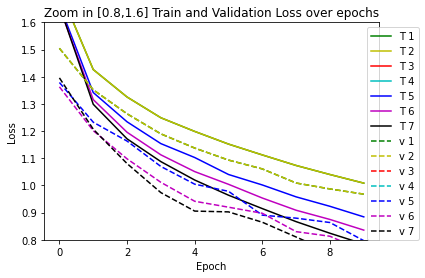

In [ ]:
plt.plot(train_loss1, label = 'T 1', color = 'g' )
plt.plot(train_loss2, label = 'T 2', color = 'y')
plt.plot(train_loss3, label = 'T 3', color = 'r')
plt.plot(train_loss4, label = 'T 4', color = 'c')
plt.plot(train_loss5, label = 'T 5', color = 'b')
plt.plot(train_loss6, label = 'T 6', color = 'm')
plt.plot(train_loss7, label = 'T 7', color = 'k')

plt.plot(valid_loss1, label = 'v 1', ls= '--', color = 'g')
plt.plot(valid_loss2, label = 'v 2', ls= '--', color = 'y')
plt.plot(valid_loss3, label = 'v 3', ls= '--', color = 'r')
plt.plot(valid_loss4, label = 'v 4', ls= '--', color = 'c')
plt.plot(valid_loss5, label = 'v 5', ls= '--', color = 'b')
plt.plot(valid_loss6, label = 'v 6', ls= '--', color = 'm')
plt.plot(valid_loss7, label = 'v 7', ls= '--', color = 'k')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title( 'Zoom in [0.8,1.6] Train and Validation Loss over epochs')
plt.legend(bbox_to_anchor=(0.95, 1))
plt.ylim(0.8, 1.6)
plt.savefig('Zoomlossepoch.png')

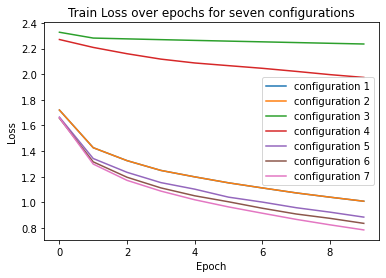

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss1, label = 'configuration 1', )
plt.plot(train_loss2, label = 'configuration 2')
plt.plot(train_loss3, label = 'configuration 3')
plt.plot(train_loss4, label = 'configuration 4')
plt.plot(train_loss5, label = 'configuration 5')
plt.plot(train_loss6, label = 'configuration 6')
plt.plot(train_loss7, label = 'configuration 7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title( 'Train Loss over epochs for seven configurations')
plt.legend()
#plt.show()
plt.savefig('trainloss7conf.png')

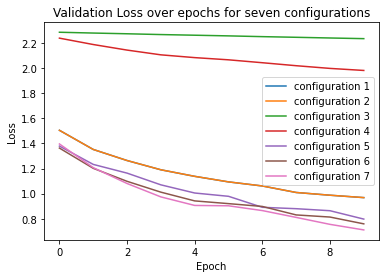

In [ ]:
plt.plot(valid_loss1, label = 'configuration 1')
plt.plot(valid_loss2, label = 'configuration 2')
plt.plot(valid_loss3, label = 'configuration 3')
plt.plot(valid_loss4, label = 'configuration 4')
plt.plot(valid_loss5, label = 'configuration 5')
plt.plot(valid_loss6, label = 'configuration 6')
plt.plot(valid_loss7, label = 'configuration 7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title( 'Validation Loss over epochs for seven configurations')
plt.legend()
#plt.show()
plt.savefig('validloss7conf.png')

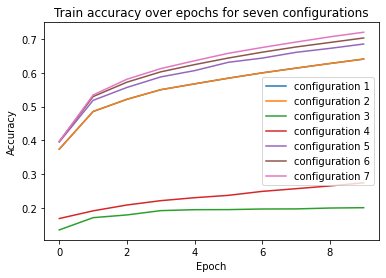

In [ ]:
plt.plot(train_ppl1, label = 'configuration 1')
plt.plot(train_ppl2, label = 'configuration 2')
plt.plot(train_ppl3, label = 'configuration 3')
plt.plot(train_ppl4, label = 'configuration 4')
plt.plot(train_ppl5, label = 'configuration 5')
plt.plot(train_ppl6, label = 'configuration 6')
plt.plot(train_ppl7, label = 'configuration 7')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title( 'Train accuracy over epochs for seven configurations')
plt.legend()
#plt.show()
plt.savefig('trainaccuracy7conf.png')

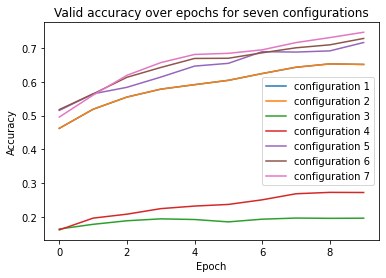

In [ ]:
plt.plot(valid_ppl1, label = 'configuration 1')
plt.plot(valid_ppl2, label = 'configuration 2')
plt.plot(valid_ppl3, label = 'configuration 3')
plt.plot(valid_ppl4, label = 'configuration 4')
plt.plot(valid_ppl5, label = 'configuration 5')
plt.plot(valid_ppl6, label = 'configuration 6')
plt.plot(valid_ppl7, label = 'configuration 7')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title( 'Valid accuracy over epochs for seven configurations')
plt.legend()
#plt.show()
plt.savefig('validaccuracy7conf.png')

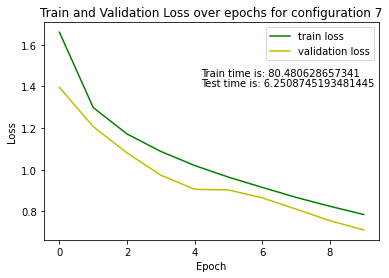

In [ ]:
import matplotlib.pyplot as plt
timeTrain7 = np.mean(train_time7)

plt.plot(train_loss7, label = 'train loss', color = 'g')
plt.plot(valid_loss7, label ='validation loss', color = 'y')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title( 'Train and Validation Loss over epochs for configuration 7')
plt.text(4.2,1.45,'Train time is: {}'.format(timeTrain7))
plt.text(4.2,1.4,'Test time is: {}'.format(test_time7))
plt.legend()
plt.show()

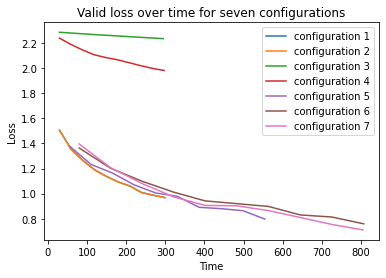

In [ ]:
#wall-clock time
plt.plot(T1, valid_loss1, label = 'configuration 1')
plt.plot(T2, valid_loss2, label = 'configuration 2')
plt.plot(T3, valid_loss3, label = 'configuration 3')
plt.plot(T4, valid_loss4, label = 'configuration 4')
plt.plot(T5, valid_loss5, label = 'configuration 5')
plt.plot(T6, valid_loss6, label = 'configuration 6')
plt.plot(T7, valid_loss7, label = 'configuration 7')
plt.ylabel('Loss')
plt.xlabel('Time')
plt.title( 'Valid loss over time for seven configurations')
plt.legend()
#plt.show()
plt.savefig('timevalidloss.png')

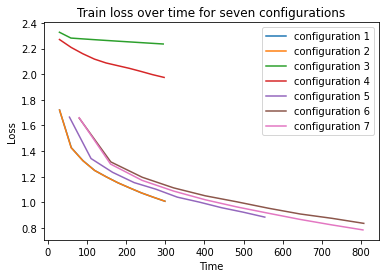

In [ ]:
#wall-clock time
plt.plot(T1, train_loss1, label = 'configuration 1')
plt.plot(T2, train_loss2, label = 'configuration 2')
plt.plot(T3, train_loss3, label = 'configuration 3')
plt.plot(T4, train_loss4, label = 'configuration 4')
plt.plot(T5, train_loss5, label = 'configuration 5')
plt.plot(T6, train_loss6, label = 'configuration 6')
plt.plot(T7, train_loss7, label = 'configuration 7')
plt.ylabel('Loss')
plt.xlabel('Time')
plt.title( 'Train loss over time for seven configurations')
plt.legend()
#plt.show()
plt.savefig('timetrainloss.png')

In [ ]:
import nvidia_smi

nvidia_smi.nvmlInit()

deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

nvidia_smi.nvmlShutdown()

Device 0: b'Tesla K80', Memory : (99.97% free): 11996954624(total), 11993808896 (free), 3145728 (used)
